In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
import os
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

In [2]:
# dataset paths
data_train_path = '../train_folder_4_classes'
data_test_path = '../test_folder_4_classes'

# Classes
classes = os.listdir(data_train_path)
num_classes = len(classes)

print("Total number of classes: " + str(num_classes))

Total number of classes: 4


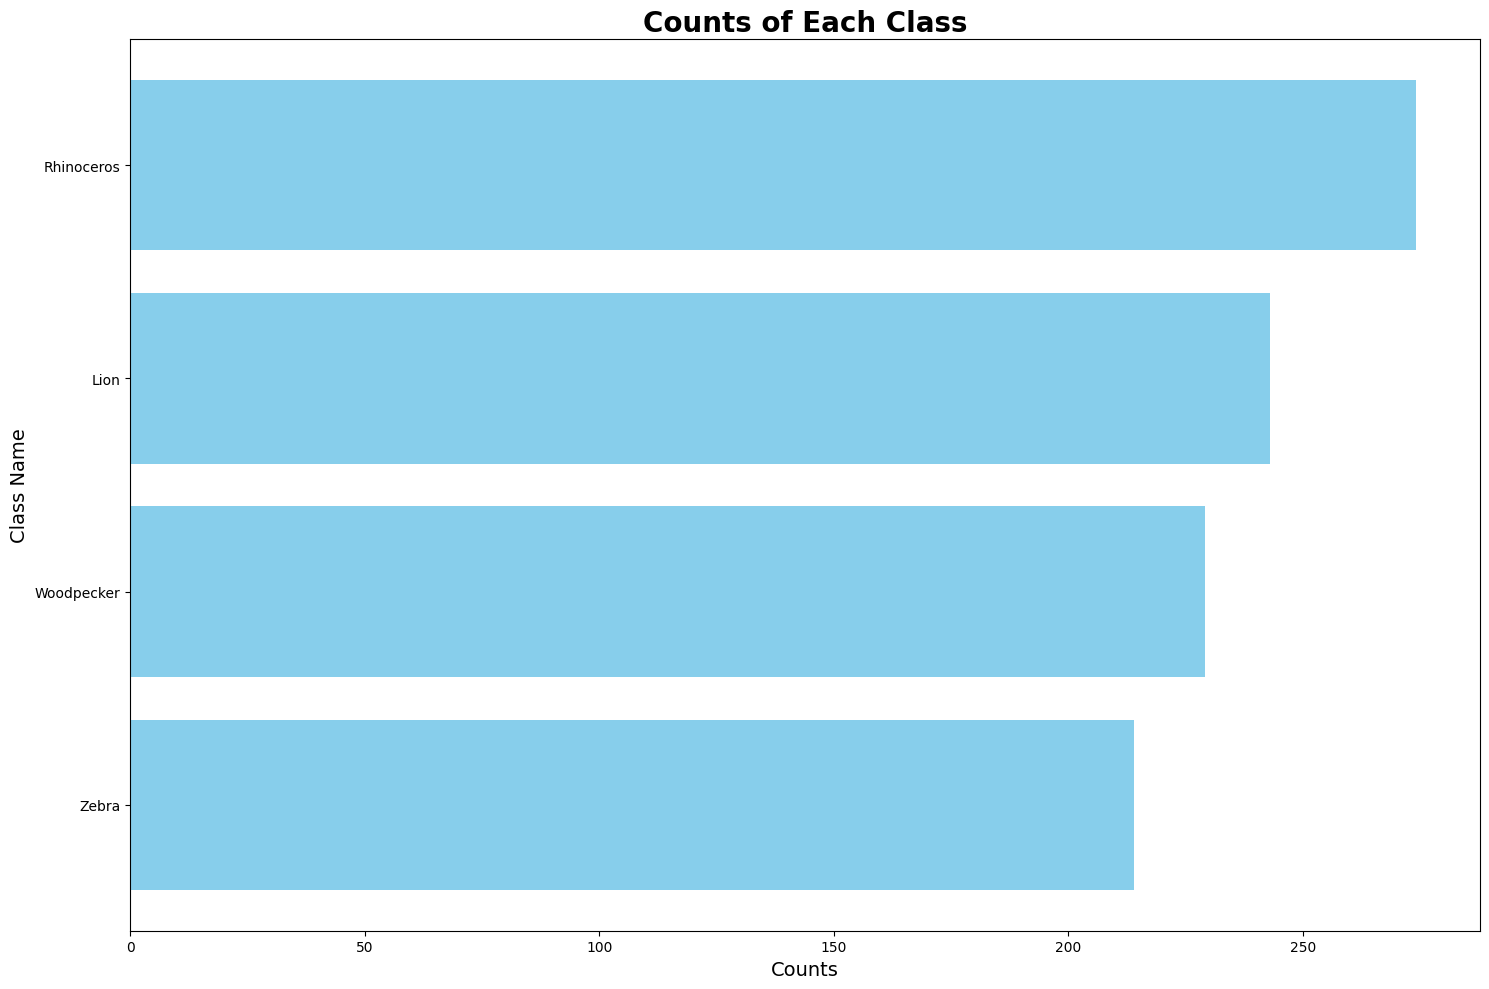

In [3]:
counts = []

for n_class in classes:
    class_path = os.path.join(data_train_path, n_class)
    count = len(os.listdir(class_path))
    counts.append((n_class, count))

counts = pd.DataFrame(counts, columns=['Class Name', 'Counts'])

counts = counts.sort_values(by='Counts', ascending=False)

plt.figure(figsize=(15, 10))
plt.barh(counts['Class Name'], counts['Counts'], color='skyblue')
plt.xlabel('Counts', fontsize=14)
plt.ylabel('Class Name', fontsize=14)
plt.title('Counts of Each Class', fontsize=20, fontweight='bold')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

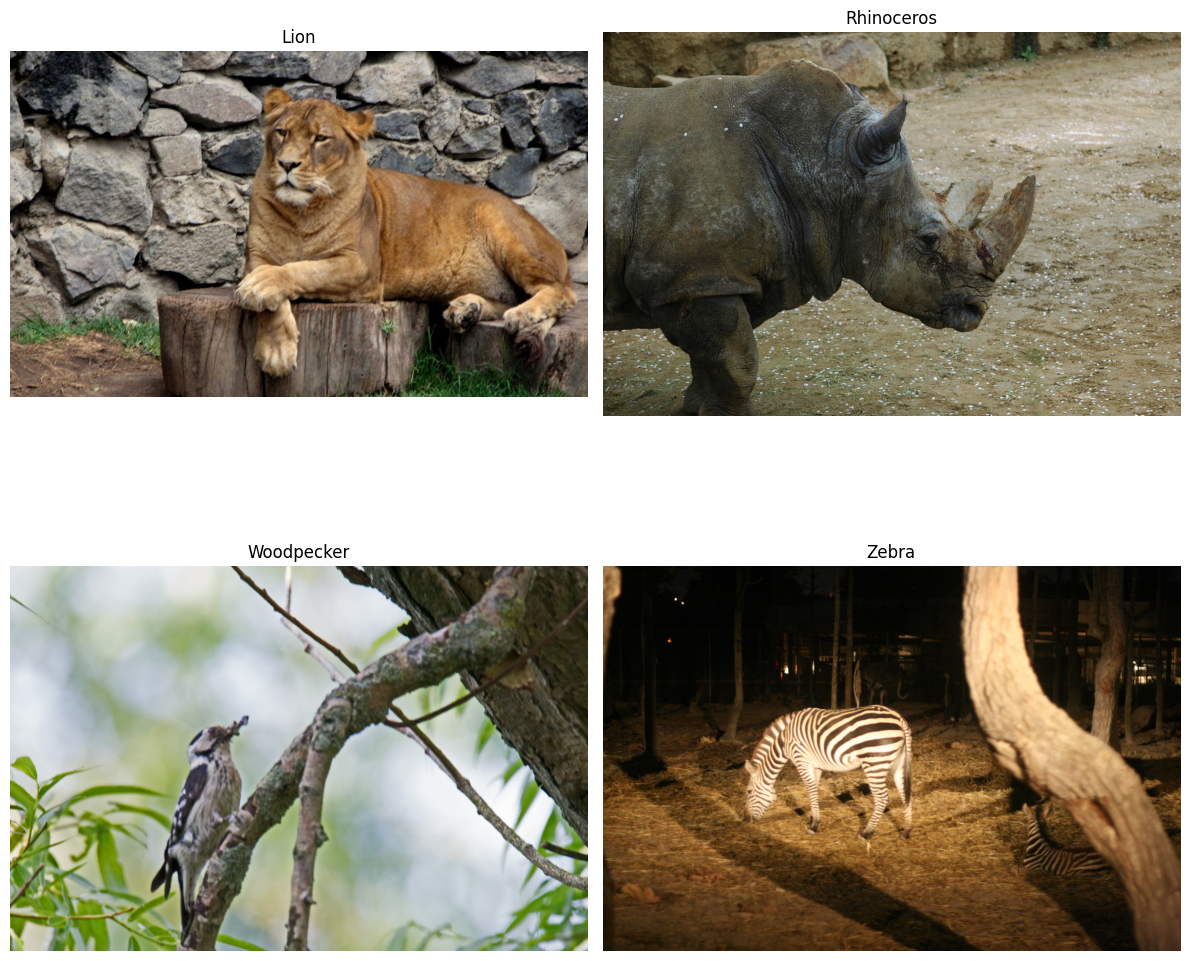

In [4]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

for i in range(len(classes)):
    class_name = classes[i]
    class_path = os.path.join(data_train_path, class_name)
    
    img_files = [f for f in os.listdir(class_path) if f.endswith('.jpg')]
    img_path = os.path.join(class_path, img_files[0])
    
    img = cv.imread(img_path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    row = i // 2
    col = i % 2

    ax[row, col].imshow(img)
    ax[row, col].axis('off')
    ax[row, col].set_title(class_name)

plt.tight_layout()
plt.show()

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
SIZE = IMAGE_SIZE[0]

# Load the full training dataset (will be split later)
full_train_ds = tf.keras.utils.image_dataset_from_directory(
    directory=data_train_path,
    labels='inferred',
    label_mode='categorical',
    class_names=classes,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
)

# Preprocessing and performance optimization
full_train_ds = full_train_ds.shuffle(1024).prefetch(tf.data.AUTOTUNE)

# Count total number of batches
total_batches = tf.data.experimental.cardinality(full_train_ds).numpy()
train_batches = int(0.9 * total_batches)
val_batches = total_batches - train_batches

# Split the dataset: 90% for training, 10% for validation
train_ds = full_train_ds.take(train_batches)
valid_ds = full_train_ds.skip(train_batches)

# Define data augmentation pipeline (applied only to training data)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
])

# Define normalization layer (used to scale pixel values between 0 and 1)
normalization_layer = tf.keras.layers.Rescaling(1./255)

# Apply augmentation and normalization to training set
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)).prefetch(tf.data.AUTOTUNE)

# Apply only normalization to validation set
valid_ds = valid_ds.map(lambda x, y: (normalization_layer(x), y)).prefetch(tf.data.AUTOTUNE)

# Load the test dataset (from a separate folder)
test_ds = tf.keras.utils.image_dataset_from_directory(
    directory=data_test_path,
    labels='inferred',
    label_mode='categorical',
    class_names=classes,
    shuffle=False,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
)

# Apply only normalization to the test set
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y)).prefetch(tf.data.AUTOTUNE)

# Print dataset sizes
print("Total batches:", total_batches + tf.data.experimental.cardinality(test_ds).numpy())
print("Train batches:", train_batches)
print("Validation batches:", val_batches)
print("Test batches:", tf.data.experimental.cardinality(test_ds).numpy())


Found 960 files belonging to 4 classes.
Found 196 files belonging to 4 classes.
Total batches: 37
Train batches: 27
Validation batches: 3
Test batches: 7


In [6]:
model = Sequential([
    # Block 1
    layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(224, 224, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Block 2
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Block 3
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Block 4 (optional, for added depth)
    layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Classification
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])


In [7]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Show the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 224, 224, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 112, 112, 64)      256       
 chNormalization)                                                
                                                      

In [ ]:
# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',          # Metric to monitor
    patience=7,                  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True    # Restore model weights from the epoch with the best value of the monitored metric
)

# Train the model with early stopping
history = model.fit(
    train_ds,
    epochs=100,
    validation_data=valid_ds,
    callbacks=[early_stopping]   # Add the early stopping callback
)


Epoch 1/100
27/27 [==============================] - 47s 2s/step - loss: 2.2058 - accuracy: 0.4988 - val_loss: 1.6575 - val_accuracy: 0.1979
Epoch 2/100
27/27 [==============================] - 46s 2s/step - loss: 0.9623 - accuracy: 0.6887 - val_loss: 1.6050 - val_accuracy: 0.3646
Epoch 3/100
27/27 [==============================] - 46s 2s/step - loss: 0.7144 - accuracy: 0.7176 - val_loss: 2.8745 - val_accuracy: 0.3333
Epoch 4/100
27/27 [==============================] - 46s 2s/step - loss: 0.5397 - accuracy: 0.8206 - val_loss: 3.7085 - val_accuracy: 0.2604
Epoch 5/100
27/27 [==============================] - 46s 2s/step - loss: 0.4341 - accuracy: 0.8252 - val_loss: 3.1800 - val_accuracy: 0.3229
Epoch 6/100
27/27 [==============================] - 46s 2s/step - loss: 0.3990 - accuracy: 0.8461 - val_loss: 2.6686 - val_accuracy: 0.3854
Epoch 7/100
27/27 [==============================] - 46s 2s/step - loss: 0.3625 - accuracy: 0.8762 - val_loss: 2.8385 - val_accuracy: 0.3646
Epoch 8/100
2

In [9]:
# Convert resutl of training to a DataFrame
result_df = pd.DataFrame(history.history)
# Show 5 tails of dataframe
result_df.tail()

loss  accuracy  val_loss  val_accuracy
28  0.052306  0.979167  0.015154      0.989583
29  0.080672  0.968750  0.004421      1.000000
30  0.050442  0.986111  0.007093      1.000000
31  0.049241  0.981481  0.001914      1.000000
32  0.045939  0.978009  0.001475      1.000000

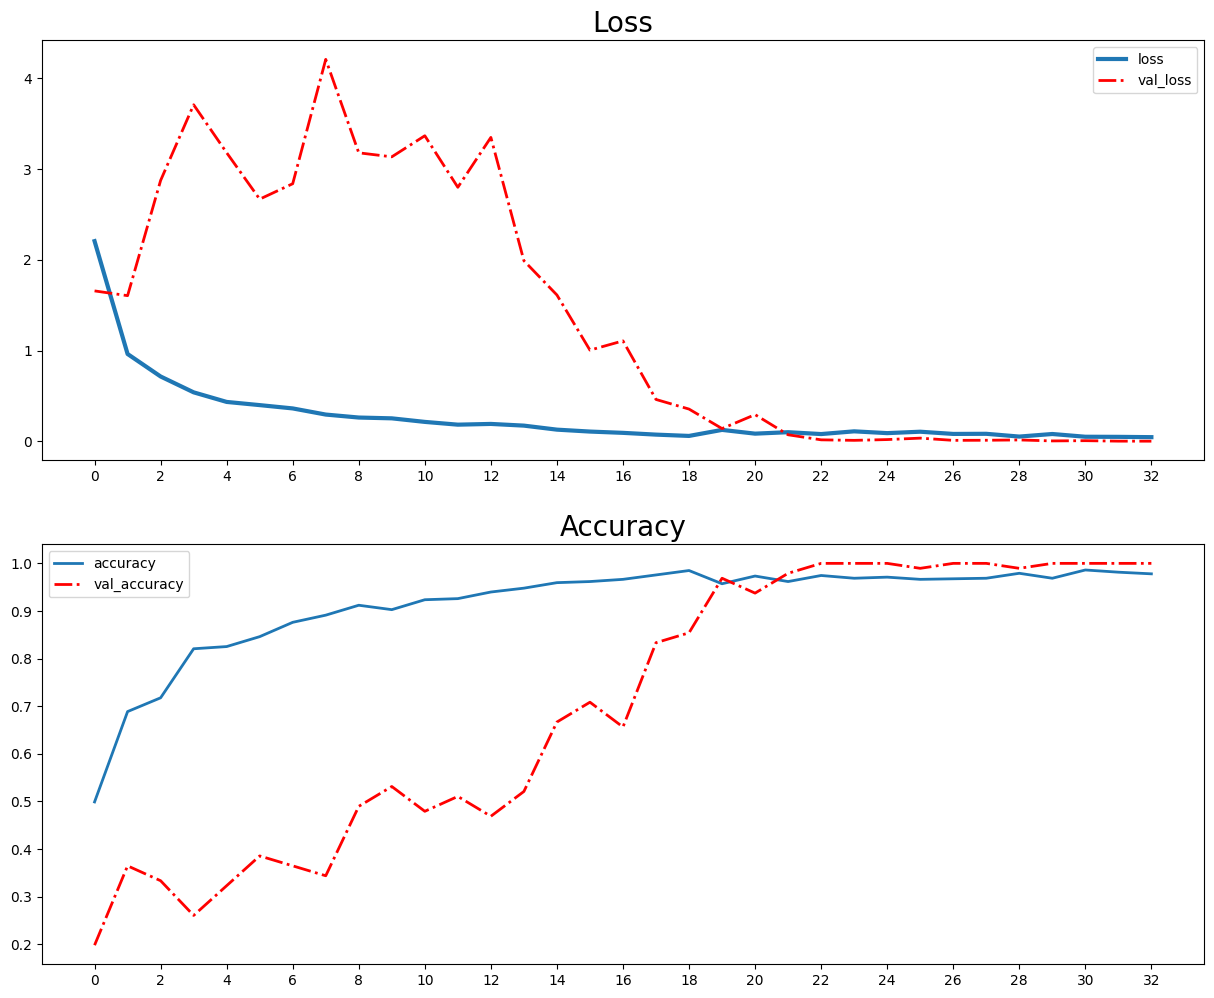

In [10]:
# Define a X variable to store range of epochs
x = np.arange(len(result_df))

# Create a plot with 3 row and 1 col with size of (15, 12)
fig, ax = plt.subplots(2, 1, figsize=(15, 12))

# AX0 : Loss
ax[0].plot(x, result_df.loss, label='loss', linewidth=3)                          
ax[0].plot(x, result_df.val_loss, label='val_loss', linewidth=2, ls='-.', c='r')
ax[0].set_title('Loss', fontsize=20)
ax[0].set_xticks(np.arange(0, len(x), 2))
ax[0].legend()

#  AX1 : Loss
ax[1].plot(x, result_df.accuracy, label='accuracy', linewidth=2)
ax[1].plot(x, result_df.val_accuracy, label='val_accuracy', linewidth=2, ls='-.', c='r')
ax[1].set_title('Accuracy', fontsize=20)
ax[1].set_xticks(np.arange(0, len(x), 2))
ax[1].legend()

# #  AX2 : Loss
# ax[2].plot(x, result_df.learning_rate, label='learning_rate', linewidth=2, marker='o')
# ax[2].set_title('learning_rate', fontsize=20)
# ax[2].set_xlabel('epochs')
# ax[2].set_xticks(np.arange(0, len(x), 2))
# ax[2].legend()

plt.show()

In [11]:
# checkpoint callback, save base model weights in "MyModel.keras".
# So, we should load it by keras.models.load_model
# best_model = tf.keras.models.load_model('MyModel.keras')

In [12]:
# # Evaluate model by model.evaluate()
# loss, accuracy = model.evaluate(test_ds)
# print()
# print(f'Loss : {loss}')
# print(f'Accuracy : {accuracy*100}%')

# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_ds)
print(f'Test Loss       : {loss:.4f}')
print(f'Test Accuracy   : {accuracy * 100:.2f}%')

# Get predictions and true labels
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

# Compute additional metrics
precision_macro = precision_score(y_true, y_pred, average='macro')
recall_macro = recall_score(y_true, y_pred, average='macro')
f1_macro = f1_score(y_true, y_pred, average='macro')

precision_micro = precision_score(y_true, y_pred, average='micro')
recall_micro = recall_score(y_true, y_pred, average='micro')
f1_micro = f1_score(y_true, y_pred, average='micro')

f1_weighted = f1_score(y_true, y_pred, average='weighted')

# Print all metrics
print()
print("Additional Evaluation Metrics:")
print(f"Macro Precision : {precision_macro:.4f}")
print(f"Macro Recall    : {recall_macro:.4f}")
print(f"Macro F1 Score  : {f1_macro:.4f}")
print(f"Micro F1 Score  : {f1_micro:.4f}")
print(f"Weighted F1     : {f1_weighted:.4f}")


7/7 [==============================] - 2s 244ms/step - loss: 0.6404 - accuracy: 0.7959
Test Loss       : 0.6404
Test Accuracy   : 79.59%
1/1 [==============================] - 0s 124ms/step

Additional Evaluation Metrics:
Macro Precision : 0.7718
Macro Recall    : 0.7787
Macro F1 Score  : 0.7743
Micro F1 Score  : 0.7959
Weighted F1     : 0.7987


1/1 [==============================] - 0s 47ms/step


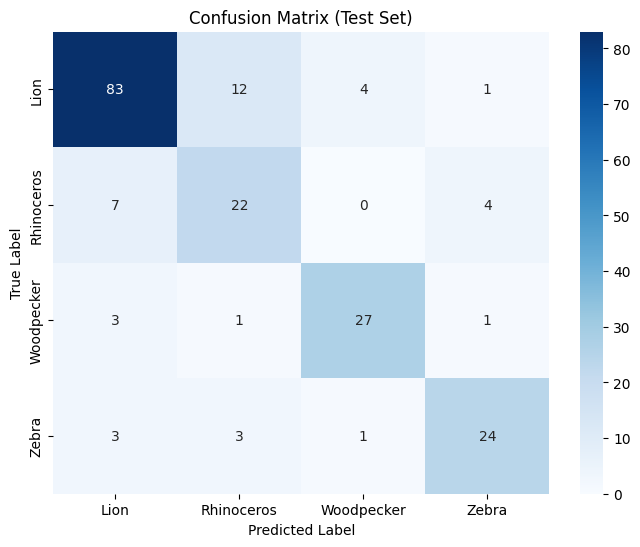

In [13]:
# Confusion Matrix

# Get predictions and true labels from the test set
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_names = classes  # use the already defined list of class names

# Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Test Set)')
plt.show()

1/1 [==============================] - 0s 32ms/step


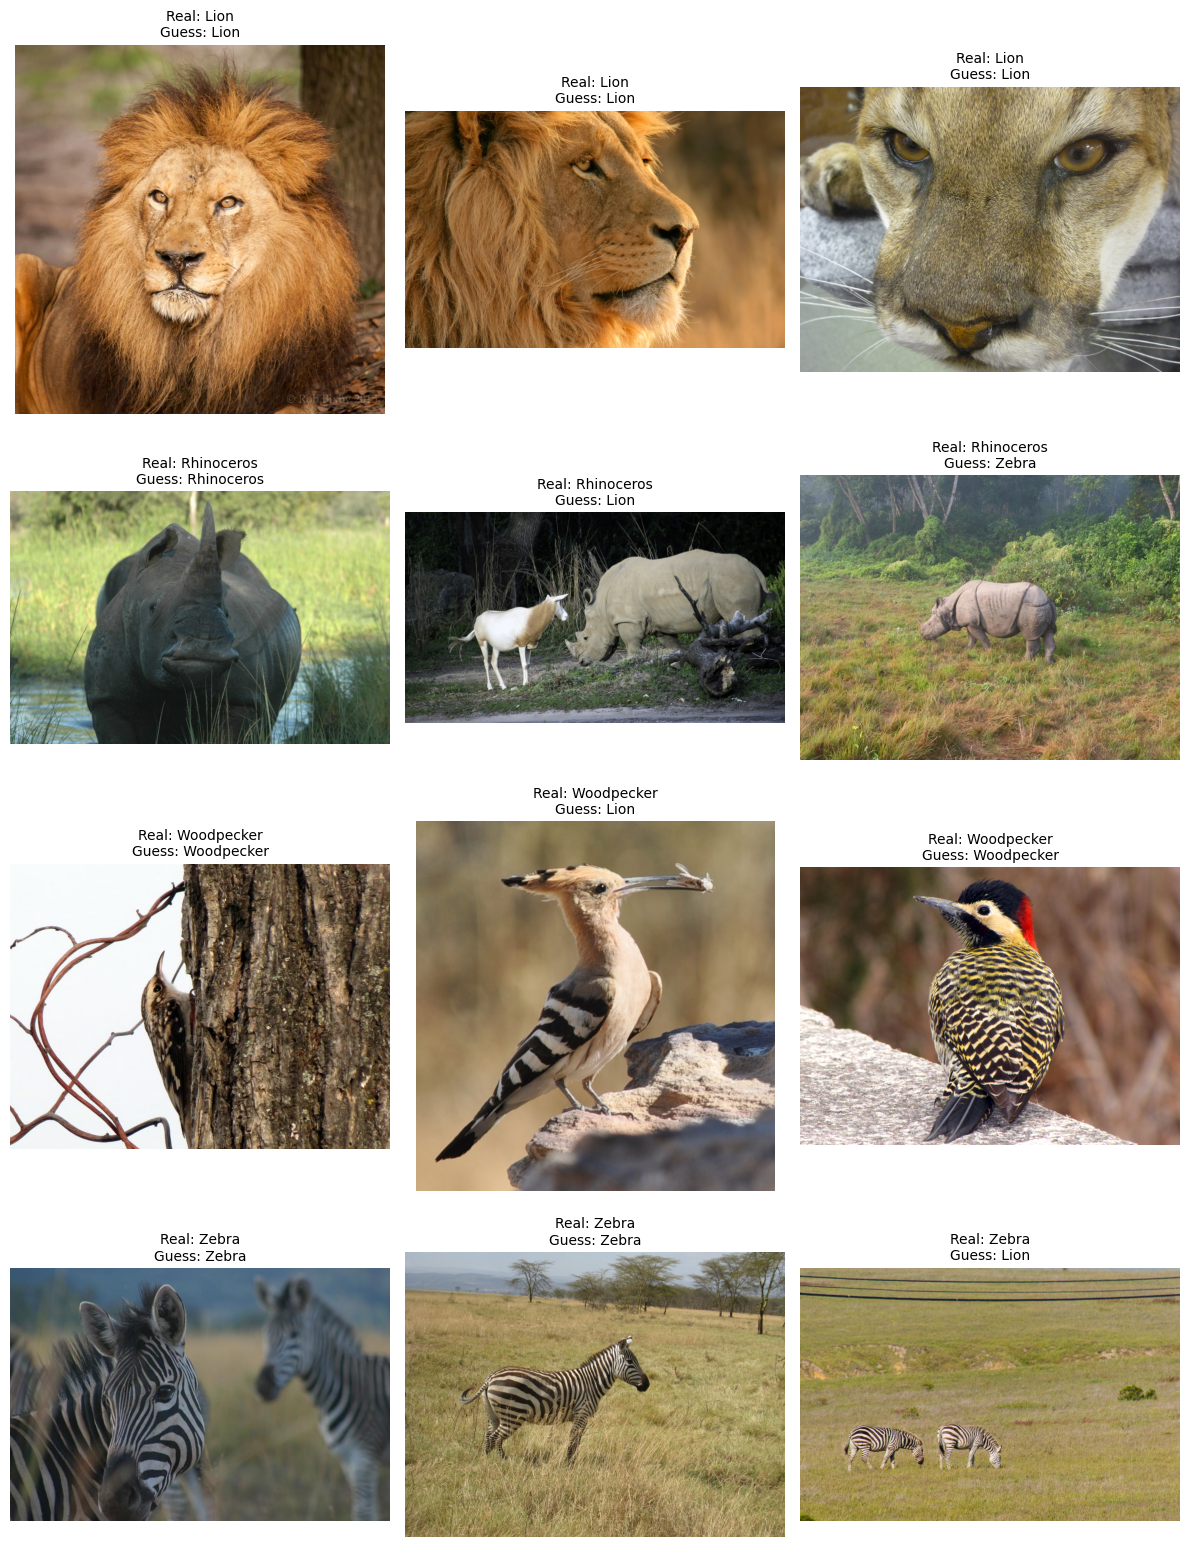

In [14]:
images_per_class = 3
total_images = len(classes) * images_per_class
rows = (total_images + 2) // 3 

fig, ax = plt.subplots(rows, 3, figsize=(12, 4 * rows))

for i, class_name in enumerate(classes):
    class_path = os.path.join(data_test_path, class_name)
    img_files = [f for f in os.listdir(class_path) if f.endswith('.jpg')]

    for j in range(images_per_class):
        idx = i * images_per_class + j
        if idx >= total_images or j >= len(img_files):
            continue  

        img_path = os.path.join(class_path, img_files[j])
        img = cv.imread(img_path)
        img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

        # Resize and normalize the image for the model
        img_resized = cv.resize(img_rgb, IMAGE_SIZE)
        input_img = normalization_layer(tf.convert_to_tensor(img_resized[np.newaxis, ...], dtype=tf.float32))[0].numpy()
        input_tensor = np.expand_dims(input_img, axis=0)

        prediction = model.predict(input_tensor)
        pred_class = tf.argmax(prediction, axis=1).numpy()[0]

        row = idx // 3
        col = idx % 3

        ax[row, col].imshow(img_rgb)
        ax[row, col].axis('off')
        ax[row, col].set_title(f"Real: {class_name}\nGuess: {classes[pred_class]}", fontsize=10)

plt.tight_layout()
plt.show()
